In [1]:
import pandas as pd
import numpy as np

In [2]:
ratings = pd.read_csv("../ml-latest-small/ratings.csv")

In [3]:
movie_rating_count = ratings.groupby("movieId").size()
# movie_rating_count[movie_rating_count.lt(4)]
# movie_rating_count.plot(kind="hist", xlim=(0, 350))

In [4]:
remove_movie_id = movie_rating_count[movie_rating_count.lt(4)].index.values.tolist()
new_ratings = ratings[~ratings.movieId.isin(remove_movie_id)]

### Functions for Prediction

In [5]:
# create symmetric similarity values matrix

def create_symmetric(similarity_df, train_movieId):
    add_missing_index = pd.Index(train_movieId).difference(similarity_df.index)
    missing_df = pd.DataFrame(index=add_missing_index, columns=similarity_df.columns).fillna(float(0))
    similarity_df = pd.concat([similarity_df, missing_df])
    similarity_df.sort_index(inplace=True)
    similarity_df = similarity_df.T # transpose to do the same for columns

    add_missing_index = pd.Index(train_movieId).difference(similarity_df.index)
    missing_df = pd.DataFrame(index=add_missing_index, columns=similarity_df.columns).fillna(float(0))
    similarity_df = pd.concat([similarity_df, missing_df])
    similarity_df = similarity_df.sort_index()
    similarity_df = similarity_df + similarity_df.T
    return(similarity_df)

In [6]:
# predict rating based on k most similar items

def predict_rating(user_id, movie_id, similarity_df, train_ratings, k):
    # select k most similar items
    similarity_row = similarity_df.loc[:,[movie_id]].sort_values(by=movie_id, axis="index", ascending=False)
    similarity_row.iloc[k:, :] = float(0)
    similarity_row.sort_index(inplace=True)
    similarity_row = similarity_row.values.flatten()

    numerator = np.dot(train_ratings.loc[[user_id],:].values.flatten(), similarity_row)

    similarity_valid = np.where(train_ratings.loc[[user_id],:].values.flatten() > 0, similarity_row, 0) # extract similarity values for items user has rated
    denominator = np.absolute(similarity_valid).sum()
    pred = numerator / denominator
    return(pred)

In [7]:
def calculate_predictions(similarity_df, train_matrix, obs_data, k=100):
    import warnings
    warnings.filterwarnings("error")
    pred_Y = []
    error_index = []

    for index, row in obs_data[["userId", "movieId"]].iterrows():
        user_id = row["userId"]
        movie_id = row["movieId"]
        try:
            pred_rating = predict_rating(user_id, movie_id, similarity_df, train_matrix, k)
            pred_Y.append(pred_rating)
        except Warning:
            error_index.append(index)
    
    new_obs_data = obs_data.drop(error_index)
    obs_Y = new_obs_data["rating"].tolist()
    return(pred_Y, obs_Y)


In [8]:
def calculate_mse(pred_Y, obs_Y):
    mse = (np.subtract(pred_Y, obs_Y)**2).sum()/len(pred_Y)
    return(mse)

### Split to Train and Test Data

In [9]:
# split data into train and test by userId
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_ratings, test_size=0.2, random_state=3, stratify=new_ratings["movieId"])

In [10]:
from scipy.sparse import csr_matrix

train_user_data = list(train["userId"])
train_ratings_data = list(train["rating"])
train_item_data = list(train["movieId"])
train_matrix = csr_matrix((train_ratings_data, (train_user_data, train_item_data)))

test_user_data = list(test["userId"])
test_ratings_data = list(test["rating"])
test_item_data = list(test["movieId"])
test_matrix = csr_matrix((test_ratings_data, (test_user_data, test_item_data)))

In [11]:
train_movieId = sorted(list(set(train_item_data)))
# test_movieId = sorted(list(set(test_item_data)))

### Similarity Computation

#### Cosine Similarity Computation

In [ ]:
# cosine_sim_values = pd.DataFrame(np.nan, columns=["item1", "item2", "cosine_similarity"])
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import trange

cosine_sim_values = []
movieId = sorted(list(set(new_ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            cos_sim = cosine_similarity(df["col1"].values.reshape(1, -1), df["col2"].values.reshape(1, -1))
            dict = {"item1": i, "item2": j, "cosine_similarity": cos_sim[0][0]}
            cosine_sim_values.append(dict)

In [ ]:
cosine_sim_values = pd.DataFrame(cosine_sim_values)
cosine_sim_values

In [ ]:
cosine_sim_values["cosine_similarity"].plot(kind="kde")

In [ ]:
cosine_sim_values.to_csv("train_cosine_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 1740]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# df.shape[0]
# if df.shape[0] >= 5:
#     cos_sim = cosine_similarity(df["col1"].values.reshape(1, -1), df["col2"].values.reshape(1, -1))
#     print("run")
# df.shape[0] < 5

#### Correlation-based Similarity Computation

In [ ]:
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange
# import warnings

# warnings.filterwarnings("error")
corr_sim_values = []
movieId = sorted(list(set(new_ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            correlation = df["col1"].corr(df["col2"])
            dict = {"item1": i, "item2": j, "correlation": correlation}
            corr_sim_values.append(dict)
            # warnings.warn(Warning())

In [ ]:
corr_sim_values = pd.DataFrame(corr_sim_values)
corr_sim_values

In [ ]:
corr_sim_values["correlation"].plot(kind="kde")

In [ ]:
corr_sim_values.to_csv("train_correlation_similarity.csv")

In [ ]:
# target = train_matrix[:, [180031, 180985]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# correlation = df["col1"].corr(df["col2"])
# # dict = {"item1": i, "item2": j, "correlation": correlation}
# correlation

#### Adjusted-Cosine Similarity Computation

In [ ]:
from tqdm.auto import trange
from math import sqrt

adj_cosine_sim_values = []
movieId = sorted(list(set(new_ratings["movieId"])))

for item1_index in trange(len(train_movieId), desc="1st loop"):
    i = train_movieId[item1_index]
    for item2_index in range(item1_index + 1, len(train_movieId)):
        j = train_movieId[item2_index]
        target = train_matrix[:, [i, j]]
        df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
        df = df.replace(0, np.nan)
        df = df[~df.isnull().any(axis=1)]
        if df.shape[0] > 2:
            df_userId = df.index.tolist()
            df_user_ratings = train[train["userId"].isin(df_userId)]
            avg_user_ratings = df_user_ratings.groupby(["userId"]).mean()["rating"]
            df_sub_avg = df.sub(avg_user_ratings, axis="index") # subtract user average
            adj_cos = (df_sub_avg["col1"]*df_sub_avg["col2"]).sum()/(sqrt((df_sub_avg["col1"]**2).sum())*sqrt((df_sub_avg["col2"]**2).sum()))
            dict = {"item1": i, "item2": j, "adjusted_cosine_similarity": adj_cos}
            adj_cosine_sim_values.append(dict)

In [ ]:
adj_cosine_sim_values = pd.DataFrame(adj_cosine_sim_values)
adj_cosine_sim_values

In [ ]:
adj_cosine_sim_values["adjusted_cosine_similarity"].plot(kind="kde")

In [ ]:
adj_cosine_sim_values.to_csv("train_adjusted_cosine_similarity.csv")

In [ ]:
# target = train_matrix[:, [1, 270]]
# df = pd.DataFrame(target.toarray(), columns=["col1", "col2"])
# df = df.replace(0, np.nan)
# df = df[~df.isnull().any(axis=1)]
# df_userId = df.index.tolist()
# df_user_ratings = train[train["userId"].isin(df_userId)]
# avg_user_ratings = df_user_ratings.groupby(["userId"]).mean()["rating"]
# df_sub_avg = df.sub(avg_user_ratings, axis="index") # subtract user average
# # adj_cos = (df_sub_avg["col1"]*df_sub_avg["col2"]).sum()/(sqrt((df_sub_avg["col1"]**2).sum())*sqrt((df_sub_avg["col2"]**2).sum()))
# df_sub_avg

### Prediction of Ratings

In [ ]:
# train_ratings = train.pivot_table(index="userId", columns="movieId", values="rating", fill_value=0)

In [38]:
def select_k(similarity_df, test_data, train_data, k_list, type_sim):
    if type_sim == "cosine":
        similarity_df = similarity_df.pivot_table(index="item1", columns="item2", values="cosine_similarity", fill_value=0)
    elif type_sim == "correlation":
        similarity_df = similarity_df.pivot_table(index="item1", columns="item2", values="correlation", fill_value=0)
    elif type_sim == "adjusted cosine":
        similarity_df = similarity_df.pivot_table(index="item1", columns="item2", values="adjusted_cosine_similarity", fill_value=0)
    
    movieId = sorted(list(set(train_data["movieId"])))
    train_ratings_matrix = train_data.pivot_table(index="userId", columns="movieId", values="rating", fill_value=0)
    similarity_df = create_symmetric(similarity_df, movieId)

    all_test_mse = {}
    all_train_mse = {}
    
    for k in k_list:
        pred_test, test_Y = calculate_predictions(similarity_df, train_ratings_matrix, test_data, k)
        test_mse = calculate_mse(pred_test, test_Y)
        all_test_mse[k] = test_mse

        pred_train, train_Y = calculate_predictions(similarity_df, train_ratings_matrix, train_data, k)
        train_mse = calculate_mse(pred_train, train_Y)
        all_train_mse[k] = train_mse
    
    return {"test_mse": all_test_mse, "train_mse": all_train_mse}

In [17]:
k = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]

In [18]:
cosine_df = pd.read_csv("./train_cosine_similarity.csv", index_col=[0])
cosine_mse = select_k(cosine_df, test, train, k, "cosine")

In [24]:
cosine_mse

{'test_mse': {10: 1.333992980992816,
  20: 1.267501303991594,
  30: 1.2262539337751106,
  40: 1.1821238075309712,
  50: 1.1604244198960068,
  60: 1.1349446055601269,
  70: 1.11663389072881,
  80: 1.1138747811548013,
  90: 1.1045417609709673,
  100: 1.0972729585095935,
  150: 1.0527198483181919,
  200: 1.0281489199534029},
 'train_mse': {10: 0.4492993761556872,
  20: 0.4893968766102389,
  30: 0.4740329747341834,
  40: 0.4545207268032431,
  50: 0.44577318855721587,
  60: 0.44199601102757374,
  70: 0.4447053725734441,
  80: 0.4479468122868366,
  90: 0.4514327804250624,
  100: 0.4539619564436651,
  150: 0.4601828137157246,
  200: 0.46779992806037046}}

In [19]:
correlation_df = pd.read_csv("./train_correlation_similarity.csv", index_col=[0])
correlation_mse = select_k(correlation_df, test, train, k, "correlation")

In [23]:
correlation_mse

{'test_mse': {10: 1.3742258063600357,
  20: 1.3148246705250821,
  30: 1.2693497129939193,
  40: 1.2407547887860468,
  50: 1.211134237094596,
  60: 1.189086581861727,
  70: 1.1754790771099994,
  80: 1.1596406641296757,
  90: 1.1455990192477736,
  100: 1.1400142046330843,
  150: 1.0943707009239398,
  200: 1.0746354686928918},
 'train_mse': {10: 0.728437782944481,
  20: 0.678042037593045,
  30: 0.6609995040316382,
  40: 0.6463993855125197,
  50: 0.6365150971802677,
  60: 0.6238689904565599,
  70: 0.6145372963230048,
  80: 0.6061051431747708,
  90: 0.5948083984594061,
  100: 0.5882575612516812,
  150: 0.5599764688148932,
  200: 0.5442086620650756}}

In [42]:
adj_cosine_df = pd.read_csv("./train_adjusted_cosine_similarity.csv", index_col=[0])
adjusted_cosine_mse = select_k(adj_cosine_df, test, train, k, "adjusted cosine")

(4020, 4158)


In [43]:
adjusted_cosine_mse

{'test_mse': {10: 1.161150325417621,
  20: 1.0689314424160508,
  30: 1.0232104751582498,
  40: 0.9984188619447819,
  50: 0.983961908489432,
  60: 0.9692144775990076,
  70: 0.9512991963086982,
  80: 0.9404743492719327,
  90: 0.9264616227004169,
  100: 0.9215651806087481,
  150: 0.8764445242601043,
  200: 0.8480212708302775},
 'train_mse': {10: 0.15215623878695128,
  20: 0.1775502771844778,
  30: 0.18143545366175656,
  40: 0.18417205267125034,
  50: 0.18662925497831923,
  60: 0.18821302826179928,
  70: 0.18878097739648725,
  80: 0.1901598540199012,
  90: 0.1928239252453886,
  100: 0.1942010475036389,
  150: 0.20285657414958227,
  200: 0.2120672624443075}}

In [84]:
cosine_mse_df = pd.DataFrame.from_dict(cosine_mse).rename_axis("k").reset_index()
cosine_mse_df["similarity_measure"] = "cosine"
correlation_mse_df = pd.DataFrame.from_dict(correlation_mse).rename_axis("k").reset_index()
correlation_mse_df["similarity_measure"] = "correlation"
adjusted_cosine_mse_df = pd.DataFrame.from_dict(adjusted_cosine_mse).rename_axis("k").reset_index()
adjusted_cosine_mse_df["similarity_measure"] = "adjusted cosine"
mse_df = pd.concat([cosine_mse_df, correlation_mse_df, adjusted_cosine_mse_df])

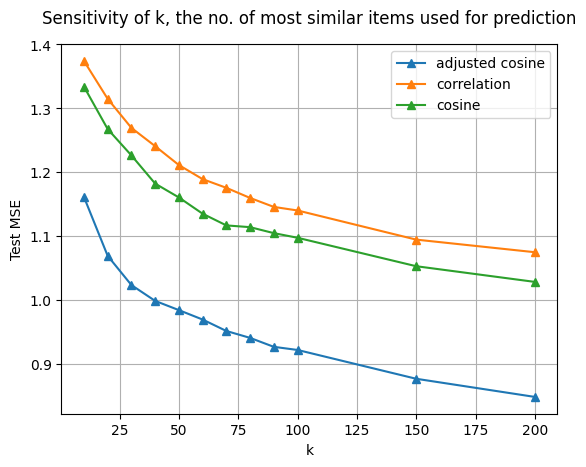

In [119]:
import matplotlib.pyplot as plt

# plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots()
legend_names = []
for key, grp in mse_df.groupby(["similarity_measure"]):
    legend_names.append(key)
    ax = grp.plot(ax=ax, kind="line", x="k", y=["test_mse"], grid=True, marker="^", legend=True)
# ax.patch.set_facecolor('white')
# plt.xticks(np.arange(0, 220, 50))
# plt.yticks(np.arange(0.8, 1.5, 0.1))
plt.legend(loc="best")
ax.legend(legend_names)
# plt.xlabel("k", labelpad=15)
plt.ylabel("Test MSE")
plt.title("Sensitivity of k, the no. of most similar items used for prediction", pad=15)
plt.show()
# plt.savefig("test_mse_vs_k.png")

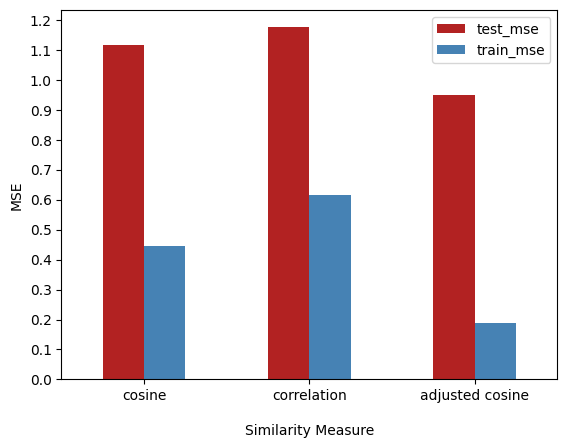

In [129]:
ax = mse_df[mse_df["k"] == 70][["test_mse", "train_mse", "similarity_measure"]].plot(kind="bar", x="similarity_measure",color=["firebrick", "steelblue"])
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 1.3, 0.1))
plt.xlabel("Similarity Measure", labelpad=15)
plt.ylabel("MSE")
plt.show()
# plt.savefig("mse_plot.png"

#### Prediction using Cosine Similarity (old)

In [ ]:
cosine_df = pd.read_csv("./train_cosine_similarity.csv", index_col=[0])
cosine_df = cosine_df.pivot_table(index="item1", columns="item2", values="cosine_similarity", fill_value=0)

cosine_df = create_symmetric(cosine_df, train_movieId)

##### Test MSE

In [ ]:
cosine_pred_Y, cosine_test_Y = calculate_predictions(cosine_df, train_ratings, test, 100)

In [ ]:
cosine_test_mse = calculate_mse(cosine_pred_Y, cosine_test_Y)
cosine_test_mse

##### Train MSE

In [ ]:
cosine_pred_train, cosine_train = calculate_predictions(cosine_df, train_ratings, train, 100)
cosine_train_mse = calculate_mse(cosine_pred_train, cosine_train)
cosine_train_mse

#### Prediction using Correlation (old)

In [ ]:
correlation_df = pd.read_csv("./train_correlation_similarity.csv", index_col=[0])
correlation_df = correlation_df.pivot_table(index="item1", columns="item2", values="correlation", fill_value=0)

correlation_df = create_symmetric(correlation_df, train_movieId)

##### Test MSE

In [ ]:
corr_pred_Y, corr_test_Y = calculate_predictions(correlation_df, train_ratings, test, 100)

In [ ]:
correlation_test_mse = calculate_mse(corr_pred_Y, corr_test_Y)
correlation_test_mse

##### Train MSE

In [ ]:
corr_pred_train, corr_train = calculate_predictions(correlation_df, train_ratings, train, 100)
correlation_train_mse = calculate_mse(corr_pred_train, corr_train)
correlation_train_mse

#### Prediction using Adjusted Cosine Similarity (old)

In [40]:
adj_cosine_df = pd.read_csv("./train_adjusted_cosine_similarity.csv", index_col=[0])
adj_cosine_df = adj_cosine_df.pivot_table(index="item1", columns="item2", values="adjusted_cosine_similarity", fill_value=0)

# adj_cosine_df = create_symmetric(adj_cosine_df, train_movieId)

In [41]:
adj_cosine_df.shape

(4020, 4158)

##### Test MSE

In [ ]:
adj_cosine_pred_Y, adj_cosine_test_Y = calculate_predictions(adj_cosine_df, train_ratings, test, 100)

In [ ]:
adj_cosine_test_mse = calculate_mse(adj_cosine_pred_Y, adj_cosine_test_Y)
adj_cosine_test_mse

##### Train MSE

In [ ]:
adj_cosine_pred_train, adj_cosine_train = calculate_predictions(adj_cosine_df, train_ratings, train, 100)
adj_cosine_train_mse = calculate_mse(adj_cosine_pred_train, adj_cosine_train)
adj_cosine_train_mse

#### MAE
For cross checking with paper

In [ ]:
np.abs(np.subtract(cosine_pred_Y, cosine_test_Y)).sum()/len(cosine_pred_Y)
np.abs(np.subtract(corr_pred_Y, corr_test_Y)).sum()/len(corr_pred_Y)
np.abs(np.subtract(adj_cosine_pred_Y, adj_cosine_test_Y)).sum()/len(adj_cosine_pred_Y)

#### Plots for MSE

In [ ]:
import matplotlib.pyplot as plt

# train_mse_data = {"Cosine": cosine_train_mse, "Correlation": correlation_train_mse, 
#                   "Adjusted Cosine": adj_cosine_train_mse}
# test_mse_data = {"Cosine": cosine_test_mse, "Correlation": correlation_test_mse, 
#                  "Adjusted Cosine": adj_cosine_test_mse}
# train_mse_df = pd.DataFrame(train_mse_data.items(), columns=["similarity_measure", "mse_value"])
# test_mse_df = pd.DataFrame(test_mse_data.items(), columns=["similarity_measure", "mse_value"])

mse_data = {"test_mse" :{"Cosine": cosine_test_mse, "Correlation": correlation_test_mse, 
            "Adjusted Cosine": adj_cosine_test_mse},
            "training_mse": {"Cosine": cosine_train_mse, "Correlation": correlation_train_mse, 
            "Adjusted Cosine": adj_cosine_train_mse}}

mse_df = pd.DataFrame.from_dict(mse_data)
mse_df = mse_df.rename_axis("similarity_measure").reset_index()

ax = mse_df.plot(kind="bar", x="similarity_measure", color=["firebrick", "steelblue"])
plt.style.use("dark_background")
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 1.3, 0.1))
plt.xlabel("Similarity Measure", labelpad=15)
plt.ylabel("MSE")
plt.show()
# plt.savefig("mse_plot.png")

## Try (ignore this section)

In [ ]:
# without zero row and col since userId and movieId starts from 1
from scipy.sparse import csr_matrix
n_users = ratings.userId.max()
n_movies = ratings.movieId.max()
ratings_data = ratings.rating
user_data = ratings.userId
item_data = ratings.movieId
adj_matrix = csr_matrix((ratings_data, (user_data - 1, item_data - 1)), shape = (n_users, n_movies))
adj_matrix.shape

In [ ]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]

### Prediction of Ratings (with Cross-Validation)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# k-fold cross validation
def cross_validation(ratings_data, similarity_df, type_sim):
    if type_sim == "cosine":
        similarity_df = similarity_df.pivot_table(index="item1", columns="item2", values="cosine_similarity", fill_value=0)
    elif type_sim == "correlation":
        similarity_df = similarity_df.pivot_table(index="item1", columns="item2", values="correlation", fill_value=0)
    elif type_sim == "adjusted cosine":
        similarity_df = similarity_df.pivot_table(index="item1", columns="item2", values="adjusted_cosine_similarity", fill_value=0)
    
    movieId = sorted(list(set(ratings_data["movieId"])))
    similarity_df = create_symmetric(similarity_df, movieId)
        
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=3)
    skf.get_n_splits(ratings_data, ratings_data["movieId"])

    all_test_mse = []
    all_train_mse = []
    for i, (train_index, test_index) in enumerate(skf.split(ratings_data, ratings_data["movieId"])):
        train = ratings_data.iloc[train_index.tolist()]
        test = ratings_data.iloc[test_index.tolist()]

        # train_item_data = list(train["movieId"])
        # train_movieId = sorted(list(set(train_item_data)))

        train_ratings = train.pivot_table(index="userId", columns="movieId", values="rating", fill_value=0)
        
        # similarity_df = create_symmetric(similarity_df, train_movieId)

        # test_mse
        pred_test, test_Y = calculate_predictions(similarity_df, train_ratings, test, 100)
        test_mse = calculate_mse(pred_test, test_Y)
        all_test_mse.append(test_mse)

        # train_mse
        pred_train, train_Y = calculate_predictions(similarity_df, train_ratings, train, 100)
        train_mse = calculate_mse(pred_train, train_Y)
        all_train_mse.append(train_mse)

        print(test_mse, train_mse)
        
    avg_test_mse = sum(all_test_mse)/len(all_test_mse)
    avg_train_mse = sum(all_train_mse)/len(all_train_mse)
    return (avg_test_mse, avg_train_mse)

In [ ]:
cosine_df = pd.read_csv("./train_cosine_similarity.csv", index_col=[0])
cosine_test_mse, cosine_train_mse = cross_validation(new_ratings, cosine_df, "cosine")

In [ ]:
cosine_test_mse, cosine_train_mse

In [ ]:
correlation_df = pd.read_csv("./train_correlation_similarity.csv", index_col=[0])
correlation_test_mse, correlation_train_mse = cross_validation(new_ratings, correlation_df, "correlation")

In [ ]:
correlation_test_mse, correlation_test_mse

In [ ]:
adj_cosine_df = pd.read_csv("./train_adjusted_cosine_similarity.csv", index_col=[0])
adj_cosine_test_mse, adj_cosine_train_mse = cross_validation(new_ratings, adj_cosine_df, "adjusted cosine")

In [ ]:
adj_cosine_test_mse, adj_cosine_train_mse